# Real-world / Business


### Problem Statment

In this task we will use machine learning to detect unstable
network which can be used to take steps towards adapting the data streaming and minimizing data packet loss.

### objectives and constraints


*   No low-latency requirement.
*   Interpretability is not much important (interested in detecting unstable network only).

### Performance metrics

For performance measure of regression task we shall the following:


*   Adjusted R2 Squared
*   Root Mean Squared Error



### Data Overview

In Our dataset we have 5 main features, by applying statistical measures on those features we get nine features as predictor (independent features) and we have a target variable (dependent) which we want to predict (approximate) as for regression task.

The dataset was splitted in two files, train and test data, the structre of the train data is as follow:

Number of instances: 379021 rows

Number of features: 10 columns

The test set on the other hand as follow:

Number of instances: 228145 rows

Number of features: 10 columns


Main Featuers Explanation (from the source):

**RTT**: Round-trip time is the amount of time it takes for a data packet to be sent to server plus the amount of time it takes for acknowledgement of that packet having been received by the client.


**Dropped Frames**: Lost  video frames in the process of data transfer. Dropped Frames indicates that the connection to remote server isn't stable or you can't keep up with your set bitrate. If too many frames are dropped, the client may be disconnected from the streaming server.

**FPS**: Frames per second is the frequency of individual images that are displayed on a video device per second. FPS can be described as the picture’s smoothness – the higher the FPS, the smoother the final picture.

**Adaptive bitrate**: Its a mode on how a bitrate is calculated.

**Auto FEC**: Automatic Forward Error Correction mode

**target**: the bitrate to be predicted


# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Reading Data

In [ ]:
df = pd.read_csv("bitrate_train.csv")

In [ ]:
print("Number of rows in train data =", df.shape[0])
print("Number of columns in train data =", df.shape[1])

Number of rows in train data = 379021
Number of columns in train data = 10


In [ ]:
df.head()

,fps_mean,fps_std,rtt_mean,rtt_std,dropped_frames_mean,dropped_frames_std,dropped_frames_max,bitrate_mean,bitrate_std,target
0,24.4,0.516398,91.1,6.723921,0.0,0.0,0.0,460.5,7.648529,616.0
1,28.6,2.065591,99.7,15.923777,0.0,0.0,0.0,616.3,155.414893,565.0
2,30.0,0.000000,98.1,11.798776,0.0,0.0,0.0,565.2,9.077445,573.0
3,30.3,0.948683,99.4,13.014522,0.0,0.0,0.0,573.8,28.350191,585.0
4,29.9,0.316228,123.2,62.476307,0.0,0.0,0.0,585.8,59.458295,555.0


In [ ]:
df.tail()

,fps_mean,fps_std,rtt_mean,rtt_std,dropped_frames_mean,dropped_frames_std,dropped_frames_max,bitrate_mean,bitrate_std,target
379016,40.0,0.0,0.0,0.0,0.0,0.0,0.0,3324.9,52.846633,3325.0
379017,40.0,0.0,0.0,0.0,0.0,0.0,0.0,3325.3,66.015234,3293.0
379018,40.0,0.0,0.0,0.0,0.0,0.0,0.0,3293.2,43.355892,3317.0
379019,40.0,0.0,0.0,0.0,0.0,0.0,0.0,3317.0,40.033319,3283.0
379020,40.0,0.0,0.0,0.0,0.0,0.0,0.0,3283.2,40.575855,3314.0


# Exploratory Data Analysis

For EDA we have three stages to do:

1. Structure investigation: Exploring the general shape of the dataset, as well as the data types of your features.

2. Quality investigation: Get a feeling for the general quality of the dataset, with regards to duplicates (Not applicable here), missing values and unwanted entries.

3. Content investigation: Once the structure and quality of the dataset is understood, we can go ahead and perform a more in-depth exploration on the features values and look at how different features relate to each other.

### General Overview

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 379021 entries, 0 to 379020
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   fps_mean             379021 non-null  float64
 1   fps_std              379021 non-null  float64
 2   rtt_mean             379021 non-null  float64
 3   rtt_std              379021 non-null  float64
 4   dropped_frames_mean  379021 non-null  float64
 5   dropped_frames_std   379021 non-null  float64
 6   dropped_frames_max   379021 non-null  float64
 7   bitrate_mean         379021 non-null  float64
 8   bitrate_std          379021 non-null  float64
 9   target               379021 non-null  float64
dtypes: float64(10)
memory usage: 28.9 MB


In [ ]:
df.isnull().sum()

fps_mean               0
fps_std                0
rtt_mean               0
rtt_std                0
dropped_frames_mean    0
dropped_frames_std     0
dropped_frames_max     0
bitrate_mean           0
bitrate_std            0
target                 0
dtype: int64

So based on the previous output we don't have any missing values or any cells which containts nan or Null values and all the features we have are numerical float features.

### Descriptive Statistics

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
fps_mean,379021.0,35.231127,10.975010,10.0,28.800000,30.000000,43.600000,125.800000
fps_std,379021.0,1.725705,2.505942,0.0,0.316228,0.942809,2.233582,307.167273
rtt_mean,379021.0,49.623858,94.781098,0.0,14.300000,32.200000,55.900000,12898.400000
rtt_std,379021.0,12.763672,112.684460,0.0,0.699206,1.433721,4.948625,40721.933293
dropped_frames_mean,379021.0,0.180451,1.732890,0.0,0.000000,0.000000,0.000000,540.000000
dropped_frames_std,379021.0,0.469548,3.157866,0.0,0.000000,0.000000,0.000000,202.385770
dropped_frames_max,379021.0,1.450719,9.670928,0.0,0.000000,0.000000,0.000000,640.000000
bitrate_mean,379021.0,7516.585502,6073.992189,0.0,2773.300000,6287.200000,10187.200000,64913.500000
bitrate_std,379021.0,1603.487501,1721.021623,0.0,383.683550,1112.710010,2241.848801,26908.532303
target,379021.0,7525.396231,6070.817736,0.0,2785.000000,6296.000000,10192.000000,64913.000000


From the table aboove we can conclude that we don't have any negarive values as expected because those features measure quantity of something, also features vary in term of scaling, some of them have narrow scale and some have large scal, also some of our features have a larger std than others which mean those features maybe need to be centerd around the mean and rescale.

### Features Distribution

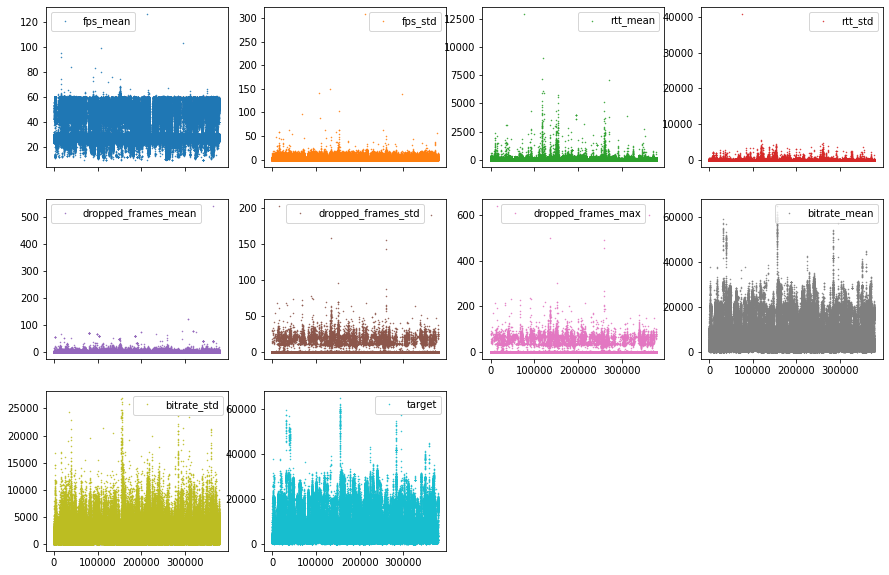

In [ ]:
df.plot(lw = 0, marker = ".", subplots = True, layout = (-1, 4), figsize = (15, 10), markersize = 1);

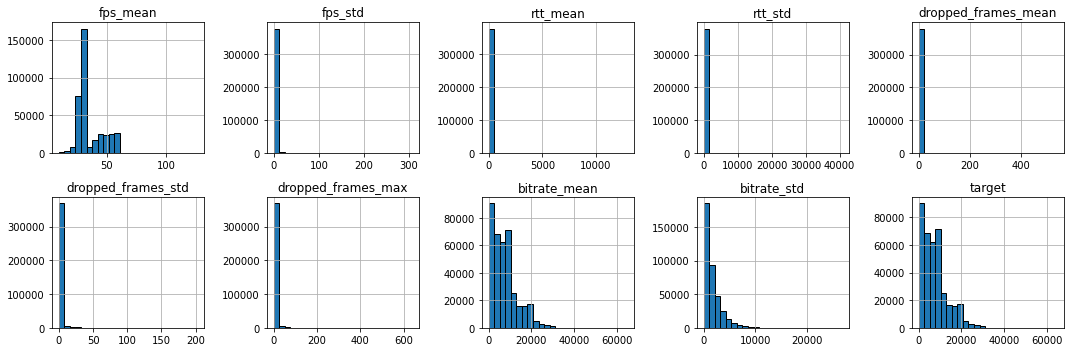

In [ ]:
df.hist(bins = 25, figsize = (15, 5), layout = (-1, 5), edgecolor = "black")
plt.tight_layout();

We can gain useful insight from the general overview of feautes plot, but still we should plot each feature on it's own.

In [ ]:
def plot_feature(feature):
  plt.figure(figsize = (18, 6))
  sns.kdeplot(feature, color = "blue", fill = True)
  plt.show()  

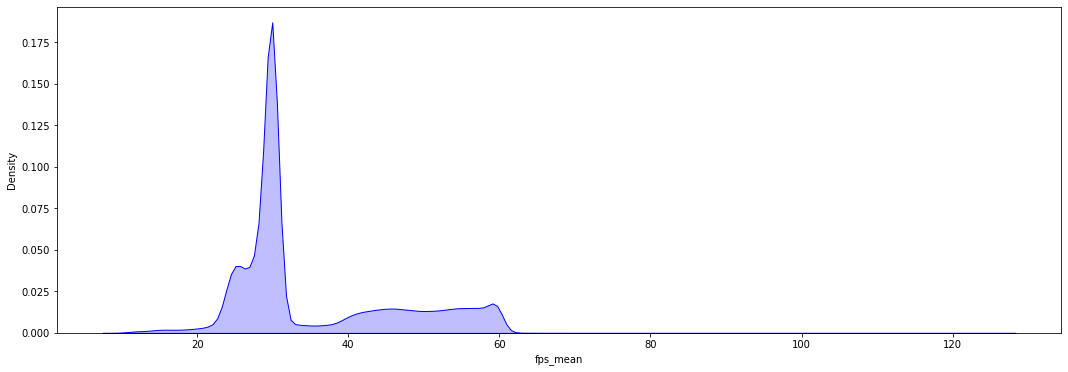

In [ ]:
plot_feature(df["fps_mean"])

It's something look like log-normal distribution but not normal, so let's try some transformation of data like log, but we can conclude that we have some variety in term of average of fps, some of them speically at first part of the plot could be outliers.

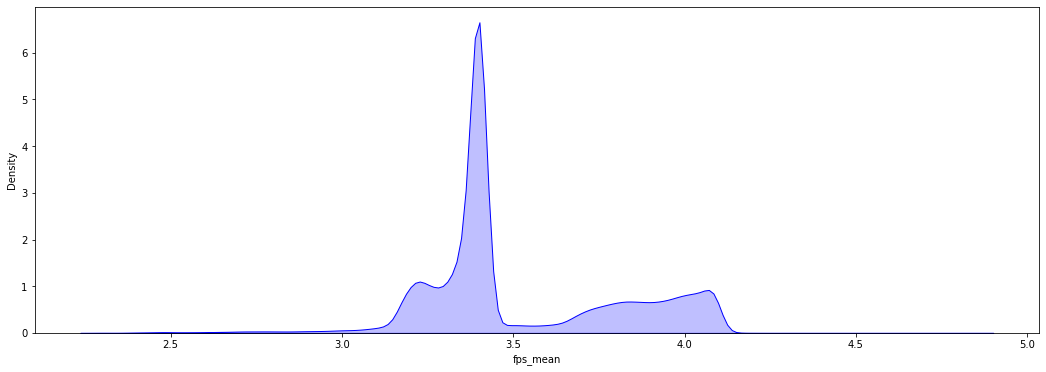

In [ ]:
plot_feature(np.log(df["fps_mean"]))

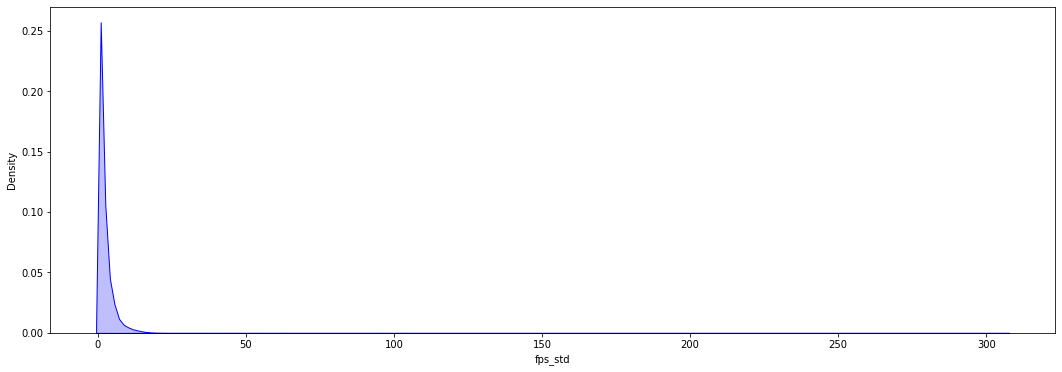

In [ ]:
plot_feature(df["fps_std"])

Given the previous plot, we can see that all the std data of fps gathered in same place, actually this was expected as the mean of std of fps was 1.725705	and the std of it was only 2.505942 so we have really narrow distribuiton of this feature, unlike the average of fps, let's try some mathematical transformation on it.

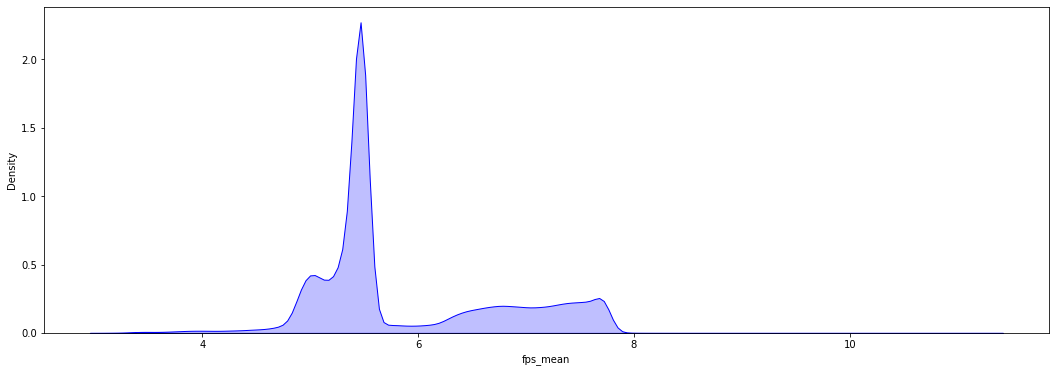

In [ ]:
plot_feature(np.sqrt(df["fps_mean"]))

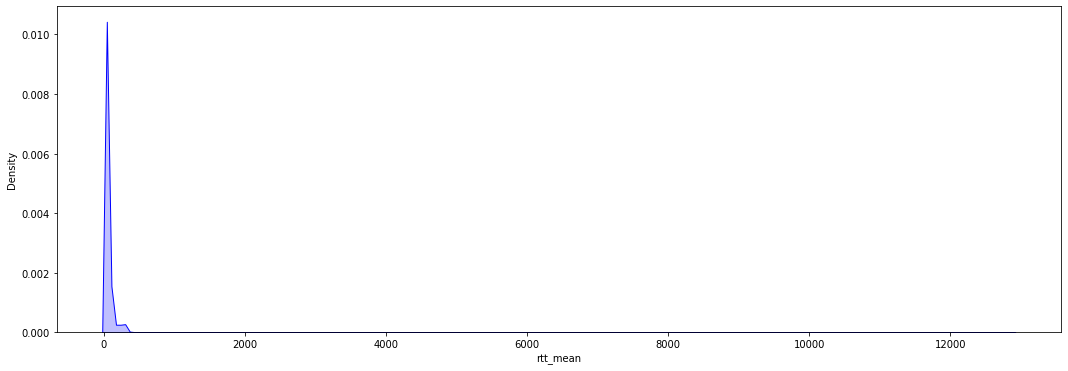

In [ ]:
plot_feature(df["rtt_mean"])

From the above plot and from the table in the describtion cell we can s see that our feature centered around 50 as a mean of this column with 94 std, as there is no negative values here hence to skewed a little bit to the right with few extremely large values to consider when cleaning, hence the mean maybe baised here by those large values, for that let's conside using the median to inspect.

In [ ]:
print("Mean of the feature =", np.mean(df["rtt_mean"]))
print("Median of the feature =", np.median(df["rtt_mean"]))

Mean of the feature = 49.62385778096728
Median of the feature = 32.2


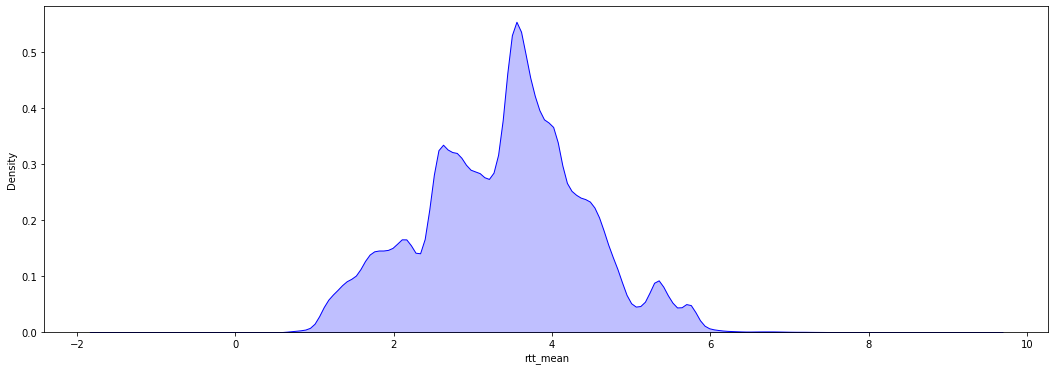

In [ ]:
plot_feature(np.log(df["rtt_mean"]))

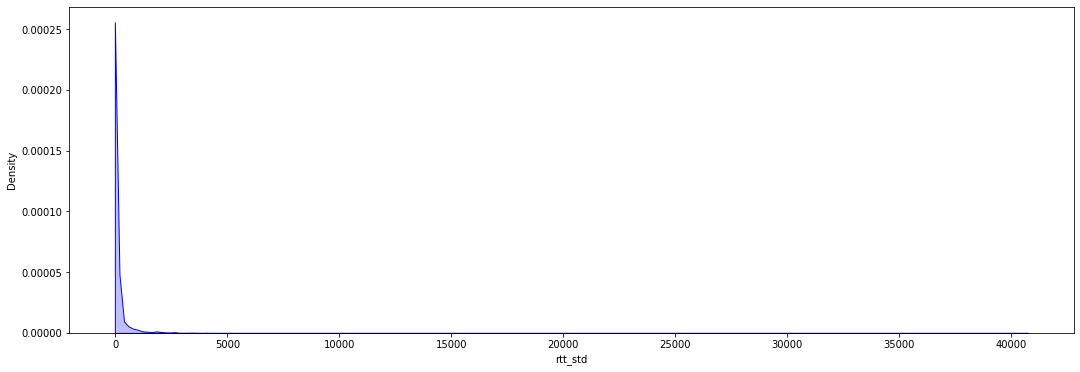

In [ ]:
plot_feature(df["rtt_std"])

In [ ]:
print("Mean of the feature =", np.mean(df["rtt_std"]))
print("Median of the feature =", np.median(df["rtt_std"]))

Mean of the feature = 12.763671881381255
Median of the feature = 1.433720877840438


Those features are biased to the right as we just said because of some large values, as the difference between mean and median not very large but still not close enough to disregard this difference.

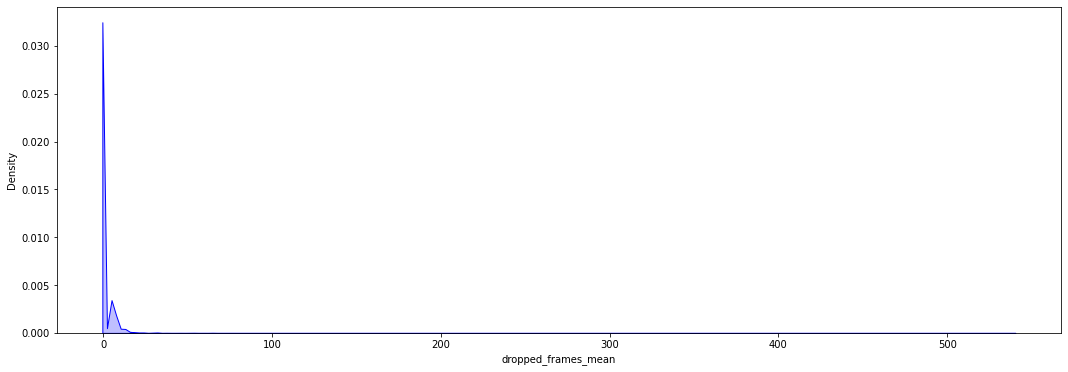

In [ ]:
plot_feature(df["dropped_frames_mean"])

This distribution look more like pareto distribution than a log normal distribution, and to investigate more we will draw it's log transformation.

we can see that it's mean is smaller than 1 but we have some values larger speicall some extrem large values comparing to the mean of this feature so let's see what is this percentage.

In [ ]:
print("Percentage of values grater than 1 =", (np.sum(df["dropped_frames_mean"] > 1) / len(df["dropped_frames_mean"])) * 100, '%')

Percentage of values grater than 1 = 2.6658153506006266 %


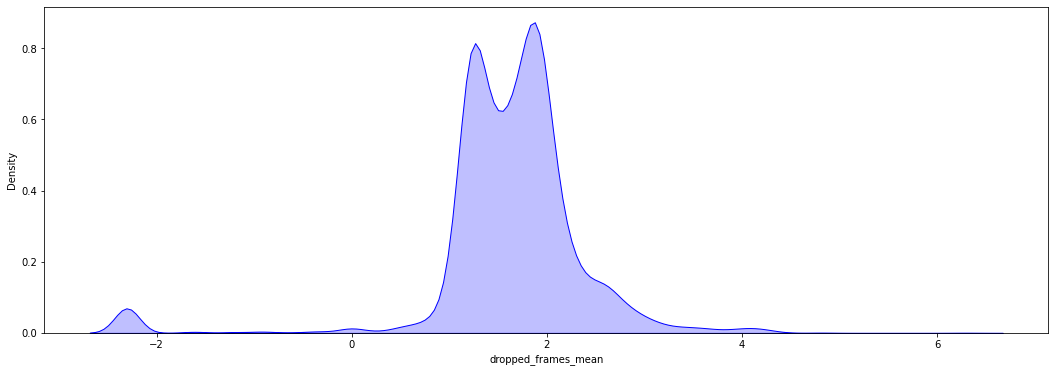

In [ ]:
plot_feature(np.log(df["dropped_frames_mean"]))

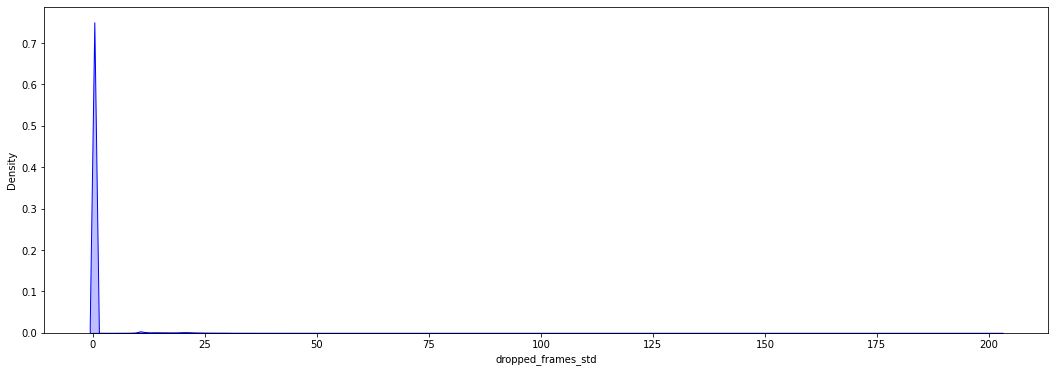

In [ ]:
plot_feature(df["dropped_frames_std"])

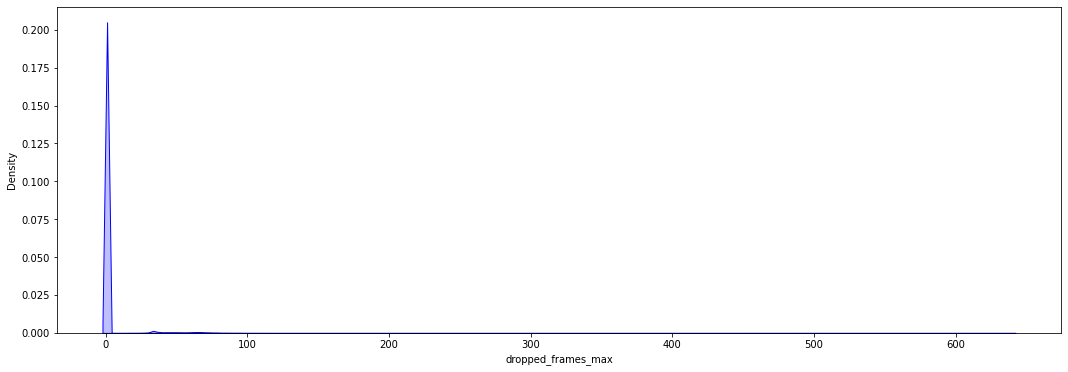

In [ ]:
plot_feature(df["dropped_frames_max"])

almost all features took the same shape as the previous features, majority of the values gathered togeather except couple of values who tend to be larger than others.

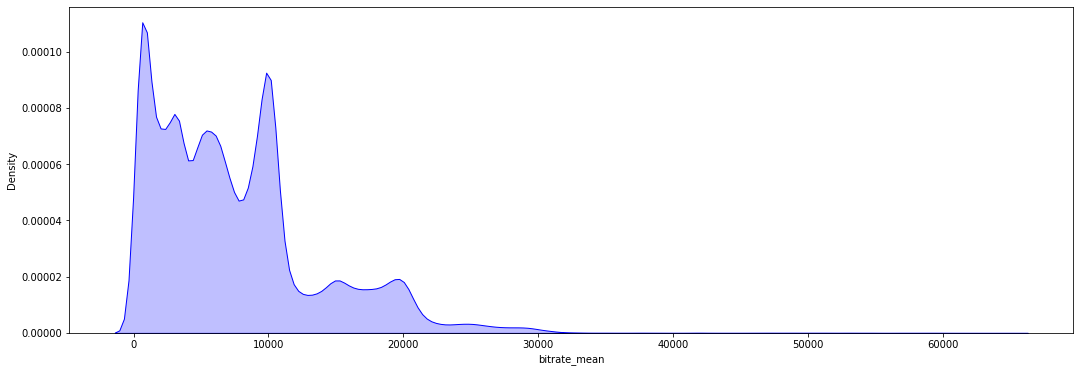

In [ ]:
plot_feature(df["bitrate_mean"])

Now from the plot above we can see that this feature has a wide scale, not all it's values gather togeather in the same plcae, but it's has a much larger scale than other features, but still values tend to be at first part of the plot taking not very large values in comparing to some vlaues at the right, let's take a look at the percentil values to see the growth of this feature.

In [ ]:
# 10th step
rg = np.arange(0, 110, 10)
perc = np.percentile(df["bitrate_mean"], rg)
for index, value in enumerate(perc):
  if index == 0:
    print("the min =", value)
  elif index == len(np.percentile(df["bitrate_mean"], rg)) - 1:
    print("the max =", value)
  else:
    print(f"{index}th percentile =", value)

the min = 0.0
1th percentile = 806.1
2th percentile = 2040.0
3th percentile = 3329.0
4th percentile = 4946.4
5th percentile = 6287.2
6th percentile = 8176.2
7th percentile = 9747.2
8th percentile = 10837.4
9th percentile = 16694.0
the max = 64913.5


In [ ]:
for i in range(len(perc) - 1):
  first, second = perc[i], perc[i + 1]
  print(f"The differenc between the {i + 1}th percentile and the {i}th percentile =", np.round(second - first, 4))

The differenc between the 1th percentile and the 0th percentile = 806.1
The differenc between the 2th percentile and the 1th percentile = 1233.9
The differenc between the 3th percentile and the 2th percentile = 1289.0
The differenc between the 4th percentile and the 3th percentile = 1617.4
The differenc between the 5th percentile and the 4th percentile = 1340.8
The differenc between the 6th percentile and the 5th percentile = 1889.0
The differenc between the 7th percentile and the 6th percentile = 1571.0
The differenc between the 8th percentile and the 7th percentile = 1090.2
The differenc between the 9th percentile and the 8th percentile = 5856.6
The differenc between the 10th percentile and the 9th percentile = 48219.5


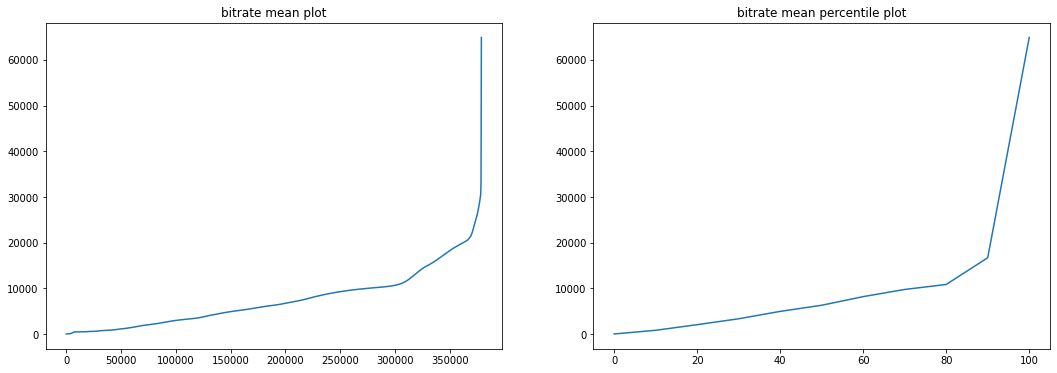

In [ ]:
plt.figure(figsize = (18, 6))
plt.subplot(121)
plt.plot(np.arange(len(df)), sorted(df["bitrate_mean"]))
plt.title("bitrate mean plot")
plt.subplot(122)
plt.plot(rg, perc)
plt.title("bitrate mean percentile plot")
plt.show()

So we have steady increasing in term of the values except for the last 10th pernectile approxiamately of our feature.

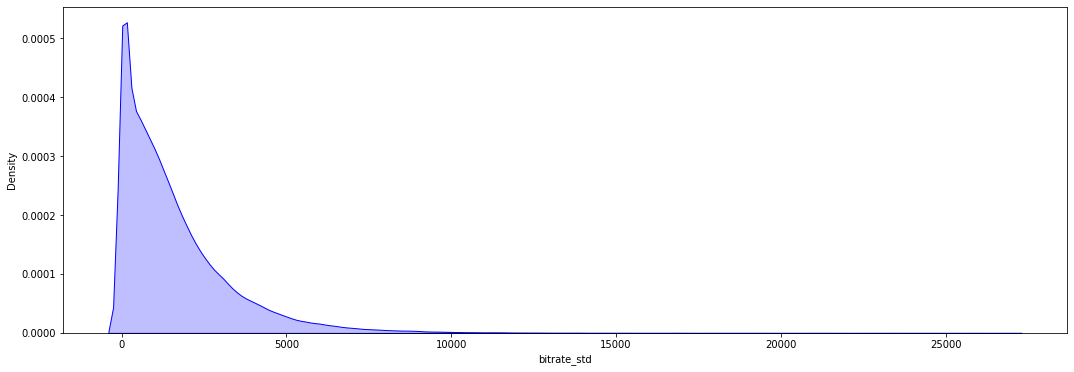

In [ ]:
plot_feature(df["bitrate_std"])

This feature look similar to the previous one but with smaller variance, it's std equal to 1603 comparing to 7516 which lead to smoother shape.

### Multicollinearity

Multicollinearity happens when independent variables are highly correlated with each other. It makes interpretation of model difficult and sometimes creates an overfitting problem. so we will check it now using correlation matrix, we can use it later in variable selection.

In [ ]:
def plot_correlation_matrix(data, threshold = None):
  corr = data.corr()
  if threshold is None:
    # plt.figure(figsize = (10, 8))
    return corr.style.background_gradient(cmap = 'coolwarm').set_precision(2)
  else:
    # get variables with more than threshold or less than -threshold correlation with the dependent variable(target)
    vars = corr[abs(corr["target"]) > threshold].index
    return corr[vars].corr().style.background_gradient(cmap = 'coolwarm').set_precision(2)

In [ ]:
plot_correlation_matrix(df)

,fps_mean,fps_std,rtt_mean,rtt_std,dropped_frames_mean,dropped_frames_std,dropped_frames_max,bitrate_mean,bitrate_std,target
fps_mean,1.00,0.29,0.01,0.00,0.04,0.09,0.09,0.21,0.19,0.20
fps_std,0.29,1.00,0.13,0.16,0.28,0.43,0.43,0.06,0.27,0.07
rtt_mean,0.01,0.13,1.00,0.70,0.04,0.06,0.06,-0.10,-0.05,-0.10
rtt_std,0.00,0.16,0.70,1.00,0.05,0.08,0.08,-0.03,0.00,-0.03
dropped_frames_mean,0.04,0.28,0.04,0.05,1.00,0.70,0.73,0.03,0.05,0.03
dropped_frames_std,0.09,0.43,0.06,0.08,0.70,1.00,0.99,0.05,0.08,0.04
dropped_frames_max,0.09,0.43,0.06,0.08,0.73,0.99,1.00,0.05,0.08,0.05
bitrate_mean,0.21,0.06,-0.10,-0.03,0.03,0.05,0.05,1.00,0.52,0.95
bitrate_std,0.19,0.27,-0.05,0.00,0.05,0.08,0.08,0.52,1.00,0.52
target,0.20,0.07,-0.10,-0.03,0.03,0.04,0.05,0.95,0.52,1.00


We can see that most of the independent variables are not really correlated togeather, which is good but some of the do, some of them correlated with the target which is good as well.

In [ ]:
plot_correlation_matrix(df, 0.4)

,bitrate_mean,bitrate_std,target
bitrate_mean,1.00,0.74,1.00
bitrate_std,0.74,1.00,0.74
target,1.00,0.74,1.00


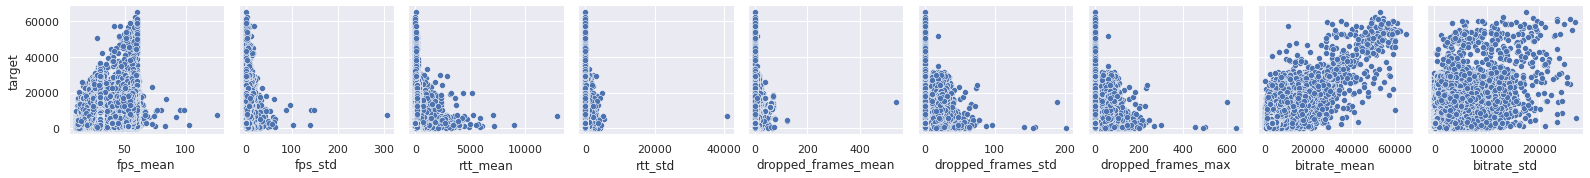

In [ ]:
sns.set(rc={'figure.figsize':(15, 10)})
sns.pairplot(df, y_vars = "target", x_vars = df.columns[:-1].values)
plt.show()

In [ ]:
def joint(feature1, feature2):
  sns.jointplot(x = feature1, y = feature1, data = df, gridsize = 10, kind = "hex")
  plt.show()

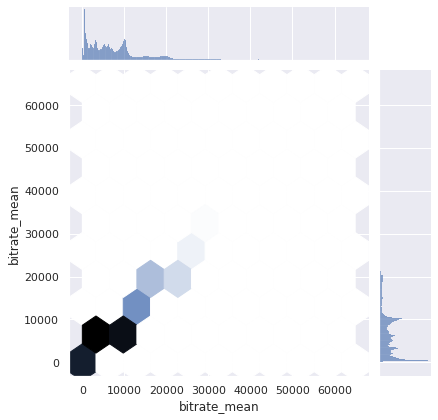

In [ ]:
joint("bitrate_mean", "bitrate_std")

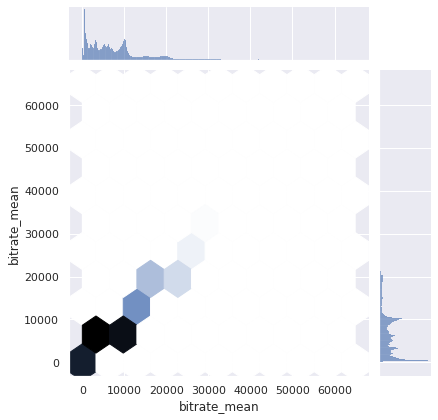

In [ ]:
joint("bitrate_mean", "target")

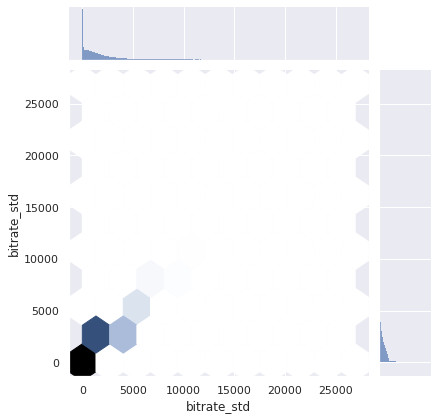

In [ ]:
joint("bitrate_std", "target")

Now, we can see that bitrate features are the most correlated with target aka dependent variable, probably those features will be more important than others but not neccessary, to be it need not to be really correlated with other features (independent variables), those two features are correlated with each other actually, to take a deeper look, let's try to calculate Variance Inflation Factor (VIF) for each independent variable then sort them, It is a measure of multicollinearity in the set of multiple regression variables. The higher the value of VIF the higher correlation between this variable and the rest, as a rule of thump if vif factor for a variable is 10 or we can consider this variable as highly correlated variable.

In [ ]:
vif = pd.DataFrame()
vif["features"] = df.columns
vif["vif_factor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
vif.sort_values(["vif_factor"], ascending = False)

,features,vif_factor
6,dropped_frames_max,68.936624
5,dropped_frames_std,63.666961
7,bitrate_mean,24.141788
9,target,23.899798
0,fps_mean,3.782273
8,bitrate_std,2.830726
2,rtt_mean,2.466115
4,dropped_frames_mean,2.306281
1,fps_std,2.172961
3,rtt_std,2.016951


# Data Cleaning (Cleansing)

problems with data can vary according to the task and the dataset, in general it is something like : Inconsistent column names, irrelevant columns, missing values, outliers, duplicate rows, the data types, unexpected values in columns.

as we don't have any missing values, we should check our data for duplicate values (rows) and removing outliers from our data, sepcially considering all the columns in order to detect duplication.

### Duplicate Records Processing

In [ ]:
duplicated = df[df.duplicated()]
print("Number of duplicated records in dataset =", len(duplicated))

Number of duplicated records in dataset = 3361


In [ ]:
# print the first five rows
duplicated.head()

,fps_mean,fps_std,rtt_mean,rtt_std,dropped_frames_mean,dropped_frames_std,dropped_frames_max,bitrate_mean,bitrate_std,target
31,30.0,0.0,82.0,0.0,0.0,0.0,0.0,575.0,0.0,575.0
32,30.0,0.0,82.0,0.0,0.0,0.0,0.0,575.0,0.0,575.0
33,30.0,0.0,82.0,0.0,0.0,0.0,0.0,575.0,0.0,575.0
34,30.0,0.0,82.0,0.0,0.0,0.0,0.0,575.0,0.0,575.0
35,30.0,0.0,82.0,0.0,0.0,0.0,0.0,575.0,0.0,575.0


In [ ]:
# print the last five rows
duplicated.tail()

,fps_mean,fps_std,rtt_mean,rtt_std,dropped_frames_mean,dropped_frames_std,dropped_frames_max,bitrate_mean,bitrate_std,target
378677,53.0,0.0,0.0,0.0,0.0,0.0,0.0,1580.0,0.0,1580.0
378678,53.0,0.0,0.0,0.0,0.0,0.0,0.0,1580.0,0.0,1580.0
378679,53.0,0.0,0.0,0.0,0.0,0.0,0.0,1580.0,0.0,1580.0
378680,53.0,0.0,0.0,0.0,0.0,0.0,0.0,1580.0,0.0,1580.0
378681,53.0,0.0,0.0,0.0,0.0,0.0,0.0,1580.0,0.0,1580.0


In [ ]:
# Remove duplicated records from our dataset, keeping only the first instance
print("Number of rows before removing duplicate records =", len(df))
df.drop_duplicates(keep = "first", inplace = True)
print("Number of rows after removing duplicate records =", len(df))

Number of rows before removing duplicate records = 379021
Number of rows after removing duplicate records = 375660


### Removing Outliers

Before removing outliers we should only check if our data contains any outliers, based on our past analysis of the data it seems that the dataset contains outliers, we should consider do more analysis to be suer that those extrem values could be considered as outliers.

As we have a skewed distributions for most of our features, we shall used IQR or Percentile method to detect outliers, then based on the number of those points we decide how to deal with them either by trimming, Capping or Binning.

In [ ]:
df.columns

Index(['fps_mean', 'fps_std', 'rtt_mean', 'rtt_std', 'dropped_frames_mean',
       'dropped_frames_std', 'dropped_frames_max', 'bitrate_mean',
       'bitrate_std', 'target'],
      dtype='object')

In [ ]:
def plot_boxplot(feature):
  sns.boxplot(df[feature])
  plt.show()

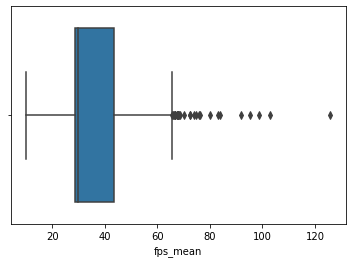

In [ ]:
plot_boxplot("fps_mean")

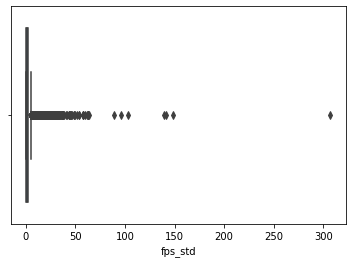

In [ ]:
plot_boxplot("fps_std")

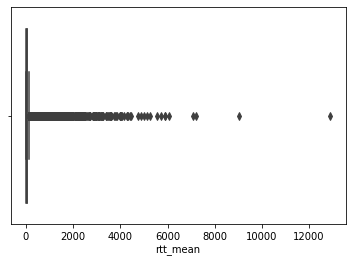

In [ ]:
plot_boxplot("rtt_mean")

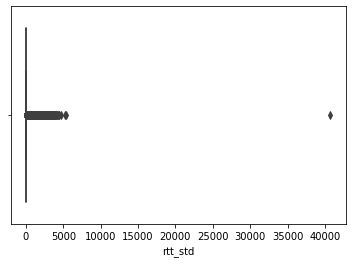

In [ ]:
plot_boxplot("rtt_std")

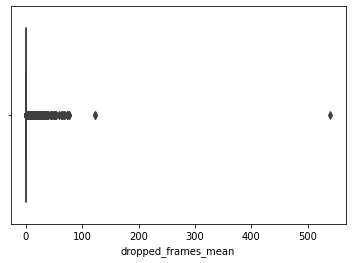

In [ ]:
plot_boxplot("dropped_frames_mean")

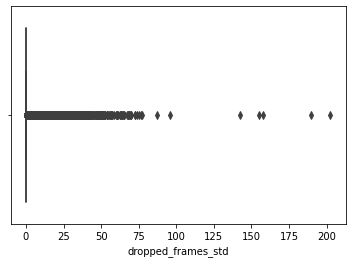

In [ ]:
plot_boxplot("dropped_frames_std")

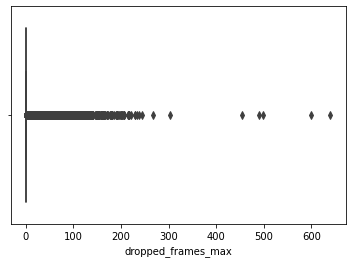

In [ ]:
plot_boxplot("dropped_frames_max")

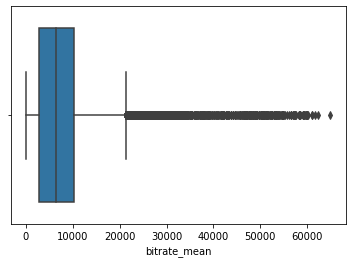

In [ ]:
plot_boxplot("bitrate_mean")

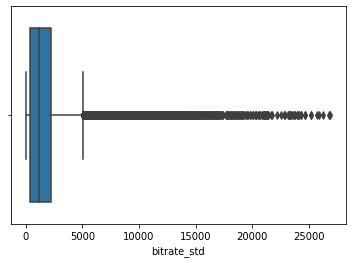

In [ ]:
plot_boxplot("bitrate_std")

Based on our previous boxplot we can see that we have some outliers but not all points outside the whiskers to be considerd as outliers so we will relay on percentile method 

In [ ]:
def number_of_outliers(feature, threshold = 0.99):
  upper_limit = df[feature].quantile(threshold)
  num_of_outliers = len(df) - len(df[(df[feature] <= upper_limit)])
  print(f"number of outliers in feature {feature} =", num_of_outliers)

In [ ]:
def get_upper_limit(feature, threshold = 0.99):
    return df[feature].quantile(threshold)

In [ ]:
number_of_outliers("fps_mean")
number_of_outliers("fps_std")
number_of_outliers("rtt_mean")
number_of_outliers("rtt_std")
number_of_outliers("dropped_frames_mean")
number_of_outliers("dropped_frames_std")
number_of_outliers("dropped_frames_max")
number_of_outliers("bitrate_mean")
number_of_outliers("bitrate_std")

number of outliers in feature fps_mean = 2939
number of outliers in feature fps_std = 3756
number of outliers in feature rtt_mean = 3740
number of outliers in feature rtt_std = 3757
number of outliers in feature dropped_frames_mean = 3634
number of outliers in feature dropped_frames_std = 3757
number of outliers in feature dropped_frames_max = 3704
number of outliers in feature bitrate_mean = 3757
number of outliers in feature bitrate_std = 3757


In [ ]:
def remove_outliers(data):
  for col in data.columns:
    data = data[(data[col] <= get_upper_limit(col))]
  return data

In [ ]:
before = len(df)
print("Number of data points before removing outliers =", len(df))

Number of data points before removing outliers = 375660


In [ ]:
df = remove_outliers(df)
print("Number of data points after removing outliers =", len(df))
print("Number of removed data points =", before - len(df))

Number of data points after removing outliers = 353774
Number of removed data points = 21886


Let's check the how our data descriptive statistcs now after removing abouyt 22K rows from it.

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
fps_mean,353774.0,34.696748,10.591439,10.0,28.800000,30.000000,42.200000,59.900000
fps_std,353774.0,1.521046,1.852292,0.0,0.316228,0.918937,2.118700,11.720827
rtt_mean,353774.0,43.380973,46.462859,0.0,14.000000,31.500000,53.400000,303.800000
rtt_std,353774.0,6.235691,15.000111,0.0,0.699206,1.429841,4.709329,180.764703
dropped_frames_mean,353774.0,0.058971,0.499988,0.0,0.000000,0.000000,0.000000,6.400000
dropped_frames_std,353774.0,0.185120,1.570918,0.0,0.000000,0.000000,0.000000,18.973666
dropped_frames_max,353774.0,0.584636,4.961235,0.0,0.000000,0.000000,0.000000,60.000000
bitrate_mean,353774.0,7233.218539,5537.545315,0.0,2775.400000,6221.100000,10091.200000,26122.900000
bitrate_std,353774.0,1501.151688,1464.380657,0.0,385.786466,1089.308042,2155.897501,7888.431336
target,353774.0,7245.350040,5521.320357,0.0,2799.000000,6243.000000,10101.000000,26116.000000


# Data PreProcessing

As we saw earlier our data features has different scaler, so we neet to rescale the data we have to achieve better result and faster performance, but first thing first, we should split data into train and cross-validation data for tuning hyperparameter later when we build our models, we will take only 10% of our data as cross-validation data and the rest will be for training as we already have test data.

### Features Scaling

In [ ]:
x_train, x_cv, y_train, y_cv = train_test_split(df[df.columns[:-1]], df["target"], test_size = 0.1)

In [ ]:
x_train.columns

Index(['fps_mean', 'fps_std', 'rtt_mean', 'rtt_std', 'dropped_frames_mean',
       'dropped_frames_std', 'dropped_frames_max', 'bitrate_mean',
       'bitrate_std'],
      dtype='object')

In [ ]:
x_cv.columns

Index(['fps_mean', 'fps_std', 'rtt_mean', 'rtt_std', 'dropped_frames_mean',
       'dropped_frames_std', 'dropped_frames_max', 'bitrate_mean',
       'bitrate_std'],
      dtype='object')

In [ ]:
print("Number or rows in train data =", len(x_train))
print("Number or rows in validation data =", len(x_cv))

print("Number or rows in target train data =", len(y_train))
print("Number or rows in target validation data =", len(y_cv))

Number or rows in train data = 318396
Number or rows in validation data = 35378
Number or rows in target train data = 318396
Number or rows in target validation data = 35378


In [ ]:
print("Number or columns in train data =", x_train.shape[1])
print("Number or column in validation data =", x_cv.shape[1])

Number or columns in train data = 9
Number or column in validation data = 9


In [ ]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_cv = scaler.transform(x_cv)

In [ ]:
def print_rows(data, n_rows):
  for i in range(n_rows):
    print(data[i])

In [ ]:
# Checking The result of scaling our data
n_rows = 5
print(f"printing the top five {n_rows} of training data")
print_rows(x_train, n_rows)

printing the top five 5 of training data
[0.85771543 0.15472709 0.080316   0.03587077 0.         0.
 0.         0.3304189  0.39629487]
[0.39679359 0.03597332 0.0437788  0.00267224 0.         0.
 0.         0.34245815 0.17031018]
[0.4008016  0.20109696 0.0921659  0.07481351 0.         0.
 0.         0.79245413 0.3404524 ]
[0.38476954 0.21583991 0.29690586 0.00233252 0.         0.
 0.         0.31644649 0.29595045]
[0.40681363 0.49266703 0.01217907 0.00373385 0.         0.
 0.         0.38305471 0.24463956]


In [ ]:
n_rows = 5
print(f"printing the top five {n_rows} of validataion data")
print_rows(x_cv, n_rows)

printing the top five 5 of validataion data
[0.85370741 0.51850268 0.14351547 0.03351854 0.         0.
 0.         0.26264312 0.42322065]
[0.30661323 0.04121261 0.38709677 0.01049633 0.         0.
 0.         0.01787321 0.00178723]
[0.39078156 0.06032909 0.23798552 0.13179375 0.         0.
 0.         0.08921291 0.33805705]
[0.69138277 0.04496665 0.13857801 0.00882435 0.         0.
 0.         0.61403979 0.63380497]
[0.73346693 0.46937943 0.02271231 0.00174939 0.         0.
 0.         0.13895854 0.21470063]


### Feature Selection

We mainly have three methods of feature selection:

1. Filter based: We specify some metric and based on that filter features. An example of such a metric could be correlation / chi-square.

2. Wrapper-based: Wrapper methods consider the selection of a set of features as a search problem. Example: Recursive Feature Elimination

3. Embedded: Embedded methods use algorithms that have built-in feature selection methods. For instance, Lasso and Random Forests have their own feature selection methods.

We will try several methods of them then we will decide what to eliminate and we shall also keep all the features we have as well just for comparison, but feature selection in this case probably will not be very useful for several reasons one of then the fact that we don't have many features to drop, so we maybe should Keep them all to gain more powerful regressor model.

In [ ]:
columns = ['fps_mean', 'fps_std', 'rtt_mean', 'rtt_std', 'dropped_frames_mean',
       'dropped_frames_std', 'dropped_frames_max', 'bitrate_mean',
       'bitrate_std']

In [ ]:
# # Chi-Square Feature Selection
# # we will take a sample of the train dataset we have so the session will not crashed
selector = SelectKBest(chi2, k = 5)
selector.fit(x_train[:40000], y_train[:40000])
chi_support = selector.get_support()
x_train = pd.DataFrame(x_train, columns = columns)
x_cv = pd.DataFrame(x_cv, columns = columns)
# chi_support = list(map(int, chi_support))
chi_feature = x_train.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')
print("The selectd features are:", chi_feature)

5 selected features
The selectd features are: ['dropped_frames_mean', 'dropped_frames_std', 'dropped_frames_max', 'bitrate_mean', 'bitrate_std']


As expected, those features were the chi square method choose were the best features based on our analysism we will use another method of feature selection using embedded method (Lasso Regression) later on when we build our model.

In [ ]:
# Removing unwanted features
x_train_new, x_cv_new = x_train[chi_feature], x_cv[chi_feature]

In [ ]:
x_train.head()

,fps_mean,fps_std,rtt_mean,rtt_std,dropped_frames_mean,dropped_frames_std,dropped_frames_max,bitrate_mean,bitrate_std
0,0.857715,0.154727,0.080316,0.035871,0.0,0.0,0.0,0.330419,0.396295
1,0.396794,0.035973,0.043779,0.002672,0.0,0.0,0.0,0.342458,0.170310
2,0.400802,0.201097,0.092166,0.074814,0.0,0.0,0.0,0.792454,0.340452
3,0.384770,0.215840,0.296906,0.002333,0.0,0.0,0.0,0.316446,0.295950
4,0.406814,0.492667,0.012179,0.003734,0.0,0.0,0.0,0.383055,0.244640


In [ ]:
x_cv.head()

,fps_mean,fps_std,rtt_mean,rtt_std,dropped_frames_mean,dropped_frames_std,dropped_frames_max,bitrate_mean,bitrate_std
0,0.853707,0.518503,0.143515,0.033519,0.0,0.0,0.0,0.262643,0.423221
1,0.306613,0.041213,0.387097,0.010496,0.0,0.0,0.0,0.017873,0.001787
2,0.390782,0.060329,0.237986,0.131794,0.0,0.0,0.0,0.089213,0.338057
3,0.691383,0.044967,0.138578,0.008824,0.0,0.0,0.0,0.614040,0.633805
4,0.733467,0.469379,0.022712,0.001749,0.0,0.0,0.0,0.138959,0.214701


In [ ]:
x_train_new.head()

,dropped_frames_mean,dropped_frames_std,dropped_frames_max,bitrate_mean,bitrate_std
0,0.0,0.0,0.0,0.330419,0.396295
1,0.0,0.0,0.0,0.342458,0.170310
2,0.0,0.0,0.0,0.792454,0.340452
3,0.0,0.0,0.0,0.316446,0.295950
4,0.0,0.0,0.0,0.383055,0.244640


In [ ]:
x_cv_new.head()

,dropped_frames_mean,dropped_frames_std,dropped_frames_max,bitrate_mean,bitrate_std
0,0.0,0.0,0.0,0.262643,0.423221
1,0.0,0.0,0.0,0.017873,0.001787
2,0.0,0.0,0.0,0.089213,0.338057
3,0.0,0.0,0.0,0.614040,0.633805
4,0.0,0.0,0.0,0.138959,0.214701


# Bulding Models

We will build 3 regression models as follow:

1. Simple Linear Regression

3. Lasso Regression

2. Polynomial Linear Regression with Regularization

We will apply each of them on selected features and on the whole dataset we have and then compare, as we have already eliminate the outliers we can use RMSE as metric to our performance.

The difference between R squared and adjusted R squared value is that R squared value assumes that all the independent variables considered affect the result of the model, whereas the adjusted R squared value considers only those independent variables which actually have, so we will implement Adjusted R2 as it's not defiened by SKLearn.

In [ ]:
def adjusted_r2(y_train, y_pred, x):
  """
  Implement Adjusted R2
  Parameters: y_train: ground truth target of the data
              y_pred:  Predicted Target of the data
              x: Actual Data
  """
  return 1 - (1 - r2_score(y_train, y_pred)) * (len(y_train) - 1) / (len(y_train) - x.shape[1] - 1)

### Simple Linear Regression

In [ ]:
regressor = LinearRegression(n_jobs = -1)
regressor.fit(x_train, y_train)
y_train_pred = regressor.predict(x_train)
y_cv_pred = regressor.predict(x_cv)

In [ ]:
print("RMSE on train data =", math.sqrt(mean_squared_error(y_train, y_train_pred)))
print("RMSE on cv data =", math.sqrt(mean_squared_error(y_cv, y_cv_pred)))

RMSE on train data = 1790.7896000160283
RMSE on cv data = 1809.2649780114684


In [ ]:
print("Adjusted R2 on train data =", adjusted_r2(y_train, y_train_pred, x_train))
print("Adjusted R2 on cv data =", adjusted_r2(y_cv, y_cv_pred, x_cv))

Adjusted R2 on train data = 0.8948821667285582
Adjusted R2 on cv data = 0.8918266987044217


In [ ]:
# Cheking the coefficent of our LinearRegression
print(regressor.coef_)

[ 4.82186079e+01  1.95901468e+02 -2.72046551e+02 -3.60954654e+02
 -1.18362792e+01 -2.38373253e+03  2.33606161e+03  2.41937017e+04
  8.25645445e+02]


### Linear Regression With L2 Regularization

In [ ]:
alphas = [0.001, 0.01, 0.1, 1, 10]
for alpha in alphas:
  sgd = SGDRegressor(alpha = alpha, max_iter = 5000, tol = 1e-6)
  sgd.fit(x_train, y_train)
  y_pred_1 = sgd.predict(x_train)
  y_cv_1 = sgd.predict(x_cv)
  sgd.fit(x_train_new, y_train)
  y_pred_2 = sgd.predict(x_train_new)
  y_cv_2 = sgd.predict(x_cv_new)
  print(f"With alpha = {alpha} train mean squared error without feature selection =", math.sqrt(mean_squared_error(y_train, y_pred_1)))
  print(f"With alpha = {alpha} train mean squared error with feature selection =", math.sqrt(mean_squared_error(y_train, y_pred_2)))
  print(f"With alpha = {alpha} validation mean squared error without feature selection =", math.sqrt(mean_squared_error(y_cv, y_cv_1)))
  print(f"With alpha = {alpha} validation mean squared error with feature selection =", math.sqrt(mean_squared_error(y_cv, y_cv_2)))
  print("*" * 75)

With alpha = 0.001 train mean squared error without feature selection = 1801.186284682275
With alpha = 0.001 train mean squared error with feature selection = 1802.2611941001037
With alpha = 0.001 validation mean squared error without feature selection = 1765.650940910148
With alpha = 0.001 validation mean squared error with feature selection = 1766.023691432619
***************************************************************************
With alpha = 0.01 train mean squared error without feature selection = 2038.5062893841641
With alpha = 0.01 train mean squared error with feature selection = 2037.6387875331902
With alpha = 0.01 validation mean squared error without feature selection = 2019.949329135541
With alpha = 0.01 validation mean squared error with feature selection = 2016.8160604018137
***************************************************************************
With alpha = 0.1 train mean squared error without feature selection = 3844.598586987766
With alpha = 0.1 train mean squa

In [ ]:
for alpha in alphas:
  sgd = SGDRegressor(alpha = alpha, max_iter = 5000, tol = 1e-6)
  sgd.fit(x_train, y_train)
  y_pred_1 = sgd.predict(x_train)
  y_cv_1 = sgd.predict(x_cv)
  sgd.fit(x_train_new, y_train)
  y_pred_2 = sgd.predict(x_train_new)
  y_cv_2 = sgd.predict(x_cv_new)
  print(f"With alpha = {alpha} train Adjusted R2 without feature selection =", adjusted_r2(y_train, y_pred_1, x_train))
  print(f"With alpha = {alpha} train Adjusted R2 with feature selection =", adjusted_r2(y_train, y_pred_2, x_train_new))
  print(f"With alpha = {alpha} validation Adjusted R2 without feature selection =", adjusted_r2(y_cv, y_cv_1, x_cv))
  print(f"With alpha = {alpha} validation Adjusted R2 with feature selection =", adjusted_r2(y_cv, y_cv_2, x_cv_new))
  print("*" * 75)

With alpha = 0.001 train Adjusted R2 without feature selection = 0.8935314864460598
With alpha = 0.001 train Adjusted R2 with feature selection = 0.8934106561158668
With alpha = 0.001 validation Adjusted R2 without feature selection = 0.8978249569515351
With alpha = 0.001 validation Adjusted R2 with feature selection = 0.897798502426147
***************************************************************************
With alpha = 0.01 train Adjusted R2 without feature selection = 0.8637748127514144
With alpha = 0.01 train Adjusted R2 with feature selection = 0.8637722723229946
With alpha = 0.01 validation Adjusted R2 without feature selection = 0.8664260392878709
With alpha = 0.01 validation Adjusted R2 with feature selection = 0.8667291348301417
***************************************************************************
With alpha = 0.1 train Adjusted R2 without feature selection = 0.5137090031225156
With alpha = 0.1 train Adjusted R2 with feature selection = 0.5086776361796073
With alpha =

The difference we gain from dropping and selecting some of features and keeping them all is not really worthy, so we will stick with complete dataset for now, as for our results we can see that Linear Regression with alpha = 0.001 is the best result on our cross validation data.

In [ ]:
sgd = SGDRegressor(alpha = 0.001, max_iter = 5000, tol = 1e-6)
sgd.fit(x_train, y_train)
y_pred = sgd.predict(x_train)
y_cv_1 = sgd.predict(x_cv)

print(f"train Adjusted R2 =", adjusted_r2(y_train, y_pred, x_train))
print(f"Cross Validation Adjusted R2 =", adjusted_r2(y_cv, y_cv_1, x_cv))

train Adjusted R2 = 0.8942693154821741
Cross Validation Adjusted R2 = 0.8913119408513738


In [ ]:
# Cheking the coefficent of our SGDRegressor
print(sgd.coef_)

[ 1.67002786e+02  3.94375897e+01 -3.77760450e+02 -4.18297673e+02
  8.69102186e+00  1.40466635e+01  1.76388045e+01  2.34527537e+04
  1.21611531e+03]


### Polynominal Linear Regression

For polynominal linear regression, let's first create more higher order features using sklearn, we will design high order features with 2, 4 and 6 degree, no regularization will be used as we shall use LinearRegression Class in this part to clarify the additive power of polynominal features.

In [ ]:
polynomial_features = PolynomialFeatures(degree = 2)
poly_regressor = LinearRegression()
x_poly = polynomial_features.fit_transform(x_train)
x_cv_poly = polynomial_features.transform(x_cv)
poly_regressor.fit(x_poly, y_train)

LinearRegression()

In [ ]:
y_pred = poly_regressor.predict(x_poly)
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
print("Rmse for polynomial model on train data =", rmse)
r2 = adjusted_r2(y_train, y_pred, x_poly)
print("Adjusted R2 for polynomial model on train data =", r2)

Rmse for polynomial model on train data = 1776.9020697760327
Adjusted R2 for polynomial model on train data = 0.8964912627025967


In [ ]:
print("number of features in polynominal space =", len(poly_regressor.coef_))

number of features in polynominal space = 55


In [ ]:
print(poly_regressor.coef_)

[-7.12618933e-10  9.66531501e+02  1.17965379e+03 -1.67313929e+02
 -2.09564719e+02 -1.97701368e+03  2.15177270e+04 -2.04978111e+04
  2.52471991e+04  1.91065285e+03 -6.77647036e+02 -7.88897495e+01
 -2.07557594e+02 -4.28746102e+02  2.93424078e+04 -1.03397427e+05
  7.59280184e+04 -8.40902983e+02  7.60476628e+02 -5.85699237e+02
 -6.07779606e+02  6.53937912e+02  6.25686888e+04 -2.30571484e+05
  1.72145225e+05 -1.80027338e+03 -2.43991369e+02  4.08785454e+02
 -9.93763191e+02 -8.18636727e+03  8.08987413e+03  5.41898754e+02
  5.26941759e+02 -1.74624887e+03  1.32790608e+03 -6.57071708e+03
  1.24229834e+04 -7.00729968e+03  8.89478407e+02 -3.09122607e+03
 -2.12785198e+05 -1.63307519e+06  2.04474226e+06 -1.27386114e+04
 -3.02491027e+04  2.85782912e+06 -3.05384095e+06  4.60040712e+04
  9.17149170e+04 -2.80210857e+03 -3.31143509e+04 -6.26564245e+04
  1.10039144e+03 -5.93499110e+03  1.59370149e+03]


### Testing Models on Test Data

In [ ]:
test_df = pd.read_csv("bitrate_test.csv")

In [ ]:
x_test, y_test = test_df[test_df.columns[:-1]], test_df["target"]

In [ ]:
print("Number of rows in test data", x_test.shape[0])
print("Number of column in test data", x_test.shape[1])
print("Number of rows in test target", len(y_test))

Number of rows in test data 228145
Number of column in test data 9
Number of rows in test target 228145


In [ ]:
x_test = scaler.transform(x_test)

### Linear Regression on Test Data

In [ ]:
print("RMSE on test data =", math.sqrt(mean_squared_error(y_test, regressor.predict(x_test))))
print("Adjusted R2 on test data =", adjusted_r2(y_test, regressor.predict(x_test), x_test))

RMSE on test data = 1959.24880084645
Adjusted R2 on test data = 0.892351803268778


### SGDRegressor on Test Data

In [ ]:
print(f"test RMSE =", math.sqrt(mean_squared_error(y_test, sgd.predict(x_test))))
print(f"test Adjusted R2 =", adjusted_r2(y_test, sgd.predict(x_test), x_test))

test RMSE = 1970.4408633458427
test Adjusted R2 = 0.8911184259401459


Polynomial Linear Regression on Test Data

In [ ]:
x_test_poly = polynomial_features.transform(x_test)
y_test_pred = poly_regressor.predict(x_test_poly)

print(f"test RMSE =", math.sqrt(mean_squared_error(y_test, y_test_pred)))
print(f"test Adjusted R2 =", adjusted_r2(y_test, y_test_pred, x_test_poly))

test RMSE = 106621.03443633649
test Adjusted R2 = -317.86066032021284
